# Estimate Pspec Window Function for All Baselines

**by Kai-Feng Chen and Steven Murray**, last updated March 19, 2025

In [1]:
import time
tstart = time.time()

In [1]:
import os
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'
import hdf5plugin  # REQUIRED to have the compression plugins available
import numpy as np
import matplotlib.pyplot as plt
import hera_pspec as hp
from IPython.display import HTML
from pathlib import Path
import simple_ps
from hera_notebook_templates.utils import parse_band_str

%matplotlib inline

ModuleNotFoundError: No module named 'simple_ps'

## Parse settings

In [ ]:
# Band settings
SINGLE_BL_PSPEC_FILE: str = "zen.LST.baseline.0_1.sum.pspec.tavg_pspec.h5"
BEAM_FILE: str = "/lustre/aoc/projects/hera/H4C/beams/NF_HERA_Vivaldi_efield_beam_healpix_pstokes.fits"

# Output Files
RESULTS_FOLDER: str = None

WINDOW_FUNCTION_ALGO: str = "old-style"  # or "adelie" or "with-inpainting"

In [ ]:
if RESULTS_FOLDER is None:
    RESULTS_FOLDER = SINGLE_BL_PSPEC_FILE.parent

In [10]:
PSPEC_FOLDER = Path(PSPEC_FOLDER)
RESULTS_FOLDER = Path(RESULTS_FOLDER)
pspec_files = sorted(PSPEC_FOLDER.glob(f'*.{PSPEC_SUFFIX}'))

# load an example single bl file
SINGLE_BL_FILE = sorted(PSPEC_FOLDER.glob(f'*.sum.uvh5'))[0]
single_bl_times = np.array(io.HERAData(SINGLE_BL_FILE).times)
hd = io.HERAData(SINGLE_BL_FILE)
data, flags, nsamples = hd.read(times=single_bl_times)

df, bands, min_freqs, max_freqs, band_slices, nchans = parse_band_str(BAND_STR, data.freqs)

In [ ]:
psc = hp.container.PSpecContainer(SINGLE_BL_PSPEC_FILE, mode='r', keep_open=False)
uvp = psc.get_pspec('stokespol', 'time_and_interleave_averaged')

## Construct a Beam Object

In [ ]:
beam_hera = hp.PSpecBeamUV(BEAM_FILE)
pre_calc_beam = []
for band_idx, pspec_band in enumerate(band_slices):
    beam_tuple = beam_hera.beam_normalized_response(pol='pI', freq=data.freqs[pspec_band])
    pre_calc_beam.append(beam_tuple)

## Old-style analysis

In [ ]:
%%time


for df in pspec_files:
    # load power spectra
    psc = hp.container.PSpecContainer(df, mode='r', keep_open=False)
    uvp = psc.get_pspec('stokespol', 'time_and_interleave_averaged')
    window_function_array = odict()
    for band_idx, pspec_band in enumerate(band_slices):
        freqs_pspec = data.freqs[pspec_band]
        ps_obj = simple_ps.simple_pspec(np.zeros(freqs_pspec.size), 
                                        np.zeros(freqs_pspec.size), None, None, 
                                        freqs=freqs_pspec,
                                        beamfunc=pre_calc_beam[band_idx], beamtype="pspec_beam",
                                        cosmo=None, little_h=True,
                                        vis_unit='Jy', taper='blackman-harris') 
        assert np.all(np.isclose(uvp.get_dlys(band_idx), ps_obj.delays))
        _M, _W = ps_obj.get_MW()
        window_function_array[band_idx] = _W.real[None, :, :, None]
    uvp.window_function_array = window_function_array
    
    # Save Results
    OUT_TAVG_PSPEC_FILE = RESULTS_FOLDER/df.with_suffix(f".tavg_pspec.h5").name
    # Create pspec container for time-averaged power spectra
    psc_tavg = hp.PSpecContainer(OUT_TAVG_PSPEC_FILE, mode='rw', keep_open=False)
    psc_tavg.set_pspec('stokespol', 'time_and_interleave_averaged', uvp, overwrite=True)

CPU times: user 7h 24min 3s, sys: 56.6 s, total: 7h 25min
Wall time: 4h 53min 26s


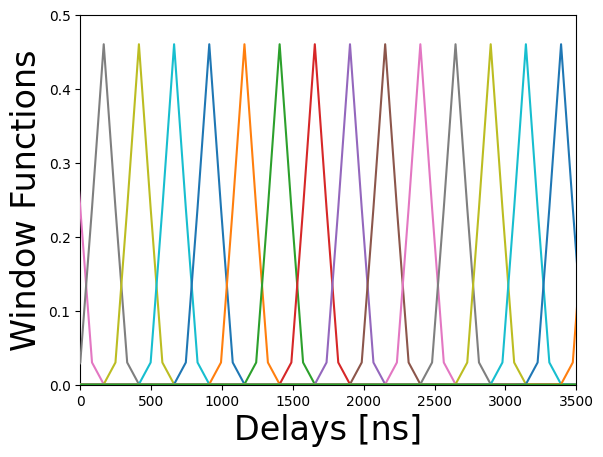

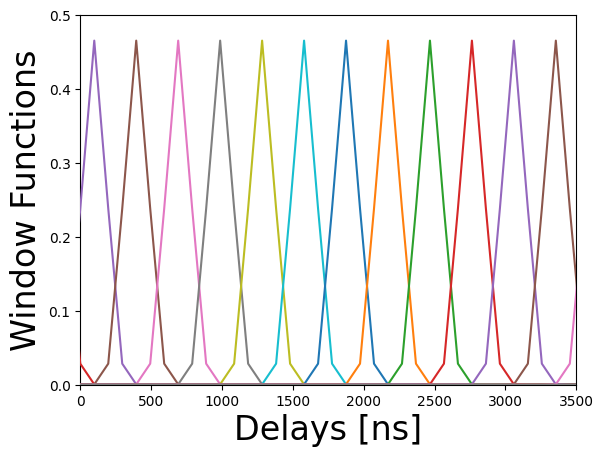

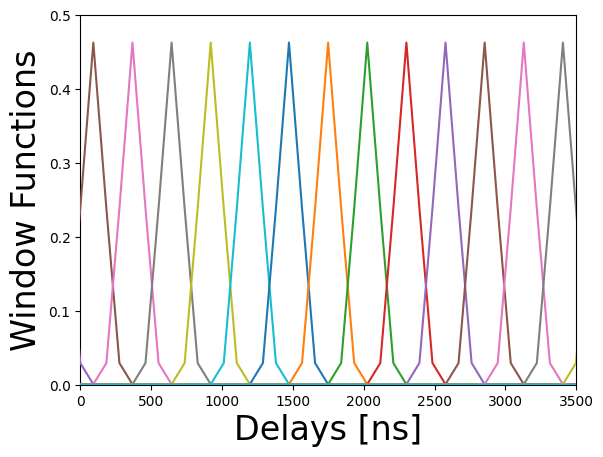

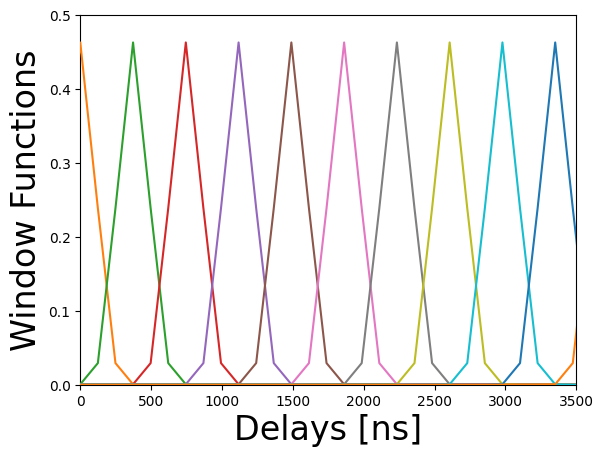

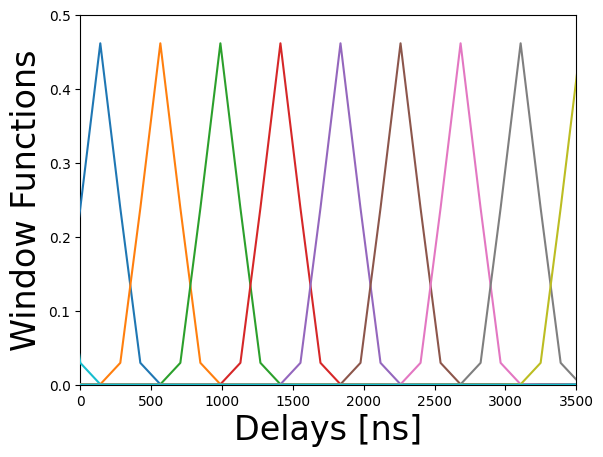

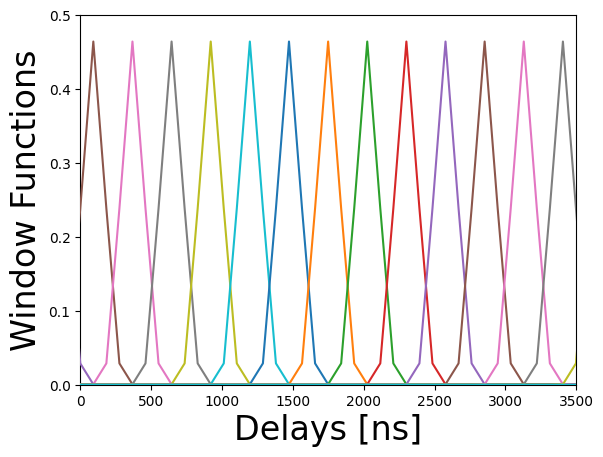

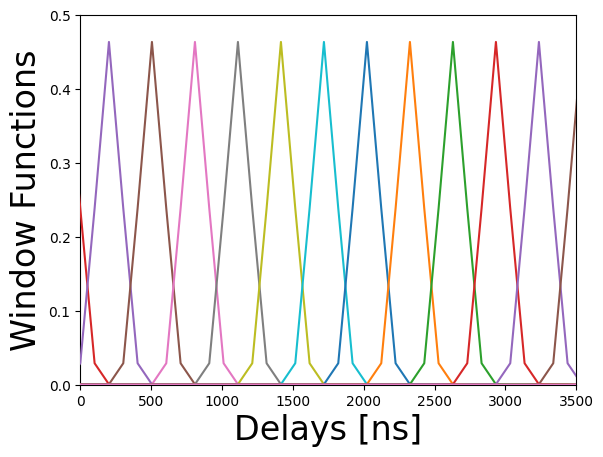

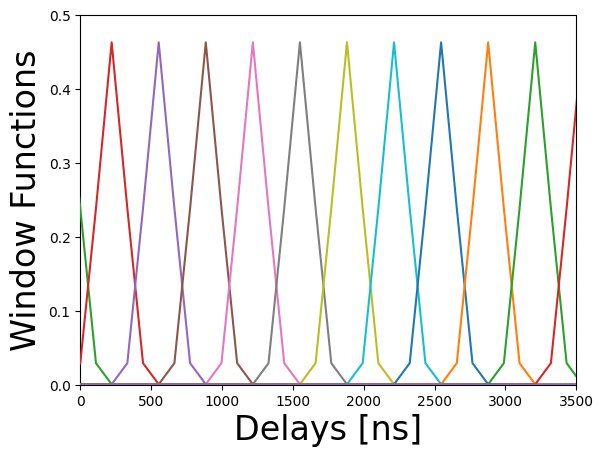

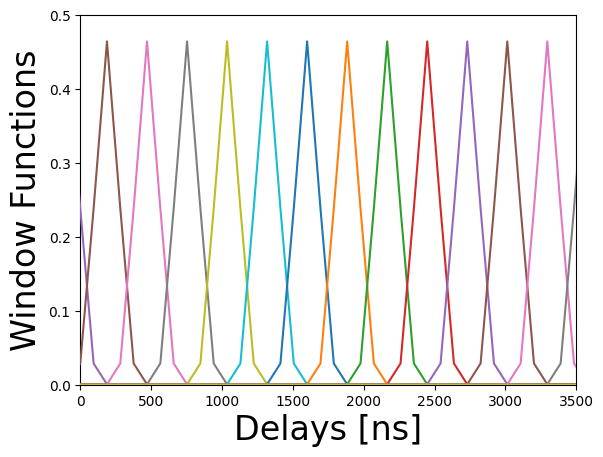

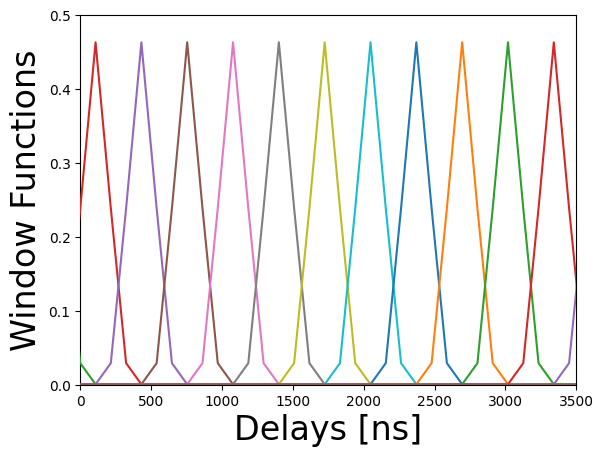

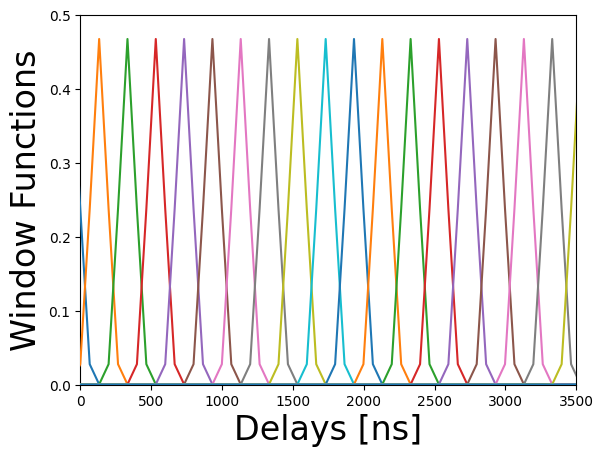

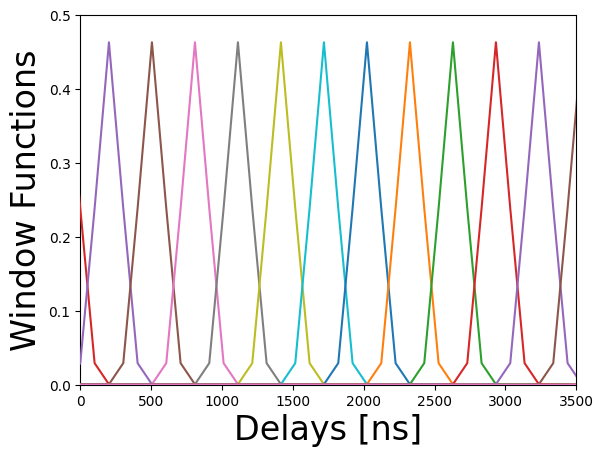

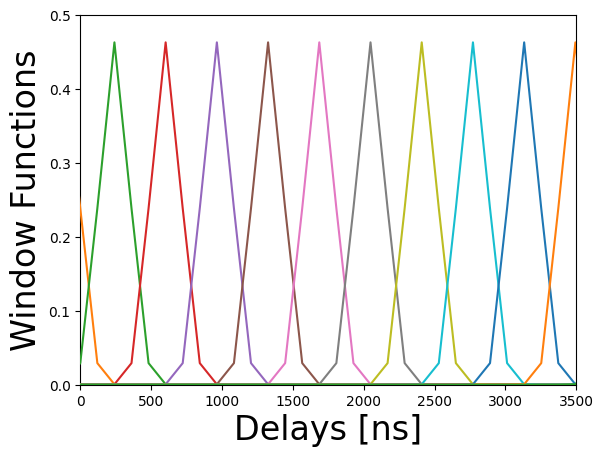

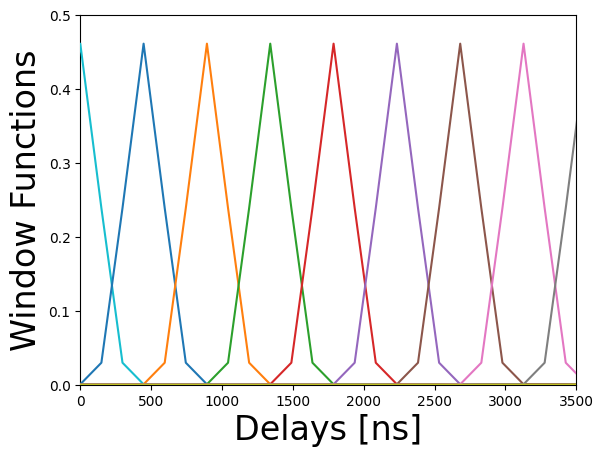

In [25]:
pspec_files_with_windows = sorted(RESULTS_FOLDER.glob(f'*{PSPEC_SUFFIX}'))
psc = hp.container.PSpecContainer(pspec_files_with_windows[0], mode='r', keep_open=False)
uvp = psc.get_pspec('stokespol', 'time_and_interleave_averaged')

for band_idx, pspec_band in enumerate(band_slices):
    key = (band_idx, uvp.get_blpairs()[0], uvp.get_polpairs()[0])
    _win = uvp.get_window_function(key)[0]
    _dly = uvp.get_dlys(band_idx)
    for i in range(_dly.size):
        if i%3 == 0:
            plt.plot(_dly*1e9, _win[i], ls='-', zorder=20)
    plt.xlim(0, 3500)
    plt.ylim(0, 0.5)
    plt.xlabel("Delays [ns]", fontsize=24)
    plt.ylabel("Window Functions", fontsize=24)
    plt.show()